In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
function fibonacci(n::Int)
    a = zeros(Float32, n)
    a[1] = 1
    a[2] = 1
    for i in 3:n
        a[i] = a[i-1] + a[i-2]
    end
    return a
end

fibonacci (generic function with 1 method)

In [3]:
fib = fibonacci(25) 
tamaño = 4
n = 25 - tamaño
# La red esperar una entrada con dimensiones (características, tamaño, lote).
X =  Array{Float32}(undef, 1, tamaño, n)
Y = Array{Float32}(undef, 1, n)  
for i = 1:n
    ventana = fib[i:i+tamaño-1]
    etiqueta = fib[i+tamaño]
    X[1, : , i] .= ventana
    Y[1, i] = etiqueta
end

In [4]:
using Lux, Random

modelo = Chain(
    Recurrence(RNNCell(1 => 1, identity; use_bias = false); return_sequence = false)
)

rng = Random.default_rng()
# Semilla aleatoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-1.7194579;;], weight_hh = Float32[1.174417;;]),), (layer_1 = (rng = TaskLocalRNG(),),))

In [5]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)          # ŷ: (1, batch)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

6.2632223f9

In [6]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.1f0), ps)

nepocas = 200
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, X, Y), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, X, Y))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 5.0130447e9


Época 2 | coste = 4.046983e9
Época 3 | coste = 3.3034327e9
Época 4 | coste = 2.7312077e9
Época 5 | coste = 2.2893059e9
Época 6 | coste = 1.94581e9
Época 7 | coste = 1.6764061e9
Época 8 | coste = 1.4628404e9
Época 9 | coste = 1.2915259e9
Época 10 | coste = 1.1523862e9
Época 11 | coste = 1.0379493e9
Época 12 | coste = 9.4265696e8
Época 13 | coste = 8.623539e8
Época 14 | coste = 7.9391226e8
Época 15 | coste = 7.349589e8
Época 16 | coste = 6.836777e8
Época 17 | coste = 6.386652e8
Época 18 | coste = 5.9882643e8
Época 19 | coste = 5.632986e8
Época 20 | coste = 5.313949e8
Época 21 | coste = 5.0256346e8
Época 22 | coste = 4.7635606e8
Época 23 | coste = 4.5240582e8
Época 24 | coste = 4.3040934e8
Época 25 | coste = 4.101142e8
Época 26 | coste = 3.913082e8
Época 27 | coste = 3.7381197e8
Época 28 | coste = 3.5747312e8
Época 29 | coste = 3.4216106e8
Época 30 | coste = 3.277637e8
Época 31 | coste = 3.141841e8
Época 32 | coste = 3.0133814e8
Época 33 | coste = 2.891527e8
Época 34 | coste = 2.77564e8


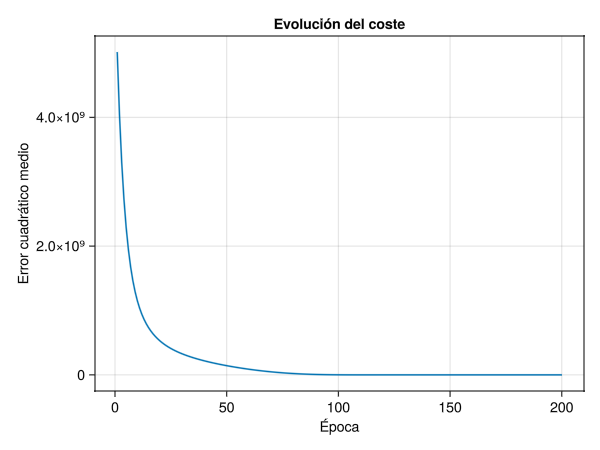

In [7]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

In [8]:
fib = fibonacci(30)
X_test = reshape(fib[end-tamaño : end-1], 1, tamaño, 1) 

y_test, _ = modelo(X_test, ps, st)
println("Predicción del término 30: ",  y_test[1, 1])
println("Término 30 de la sucesión de Fibonacci: ", fib[end])

Predicción del término 30: 831997.2
Término 30 de la sucesión de Fibonacci: 832040.0


In [9]:
println("Pesos de la entrada de la red neuronal:", ps.layer_1.weight_ih)
println("Pesos del estado de la red neuronal:", ps.layer_1.weight_hh)

Pesos de la entrada de la red neuronal:Float32[1.662782;;]
Pesos del estado de la red neuronal:Float32[-0.04483252;;]


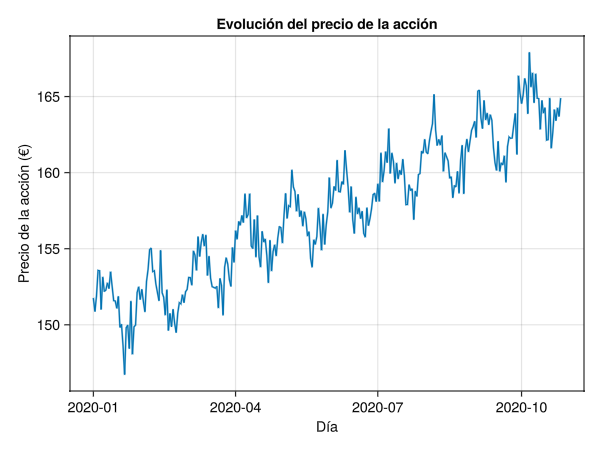

In [10]:
using CSV, DataFrames, GLMakie

# Cargamos el conjunto de datos en un data frame
df = CSV.read("datos/stock.csv", DataFrame)

# Creamos el gráfico de la evolución
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Día", ylabel = "Precio de la acción (€)", title = "Evolución del precio de la acción")

lines!(ax, df.dia, df.precio)
fig

In [11]:
using Statistics

# Simple normalization (z-score)
μ = mean(df.precio)
σ = std(df.precio)
serie = (df.precio .- μ) ./ σ     

300-element Vector{Float64}:
 -1.2770239698472932
 -1.4749432268197025
 -1.2481144154580652
 -0.8745140202741842
 -0.8789616440263692
 -1.4460336724304748
 -0.9679141190701513
 -1.1814000591752272
 -1.1591619404142832
 -1.054642782237841
 -1.1391476335294317
 -0.8923045152829369
 -1.1035666435119202
  ⋮
  1.4249074596075517
  1.5049646871469575
  1.031292757538819
  1.0379641931671029
  1.6472886472170039
  0.9112069162297167
  1.1469309750957366
  1.4782789446338223
  1.3137168658028255
  1.5027408752708586
  1.3759835983334725
  1.6450648353409114

In [12]:
function crear_secuencias(serie, tamaño)
    # Número de ventanas
    n = length(serie) - tamaño  

    # X: (características=1, tamaño=seq_len, lotes=n)
    X = Array{Float32}(undef, 1, tamaño, n)
    # Y: (etiquetas=1, lotes=n)
    Y = Array{Float32}(undef, 1, n)

    for i in 1:n
        ventana = serie[i : i + tamaño - 1]
        etiqueta = serie[i + tamaño]
        X[1, :, i] .= ventana
        Y[1, i] = etiqueta
    end

    return X, Y
end

X, Y = crear_secuencias(serie, 50)

(Float32[-1.2770239 -1.4749433 … -1.7551435 -1.501629;;; -1.4749433 -1.2481145 … -1.501629 -1.6973244;;; -1.2481145 -0.87451404 … -1.6973244 -1.4393623;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[-1.6973244 -1.4393623 … 1.3759836 1.6450648])

In [13]:
Xentrenamiento, Yentrenamiento = X[:, :, 1:200], Y[:, 1:200]
Xtest, Ytest = X[:, :, 201:end], Y[:, 201:end]

(Float32[0.08839652 0.09062033 … 1.3515216 1.1980786;;; 0.09062033 0.3797159 … 1.1980786 1.6117077;;; 0.3797159 0.29298723 … 1.6117077 1.3248359;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[1.6117077 1.3248359 … 1.3759836 1.6450648])

In [14]:
using Lux, Random
modelo = Chain(
    Recurrence(RNNCell(1 => 32); return_sequence = false),
    Dense(32 => 1)
)

rng = Random.default_rng()
# Semilla aletoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-0.30396008; 0.20760956; … ; -0.24947801; 0.095708035;;], weight_hh = Float32[-0.60596937 0.23632404 … -0.38938454 -0.6061492; 0.20912634 -0.1782639 … 0.16347872 0.3233644; … ; 0.12737364 0.26083985 … -0.07924062 -0.10240463; -0.41276667 -0.3120628 … -0.813448 -0.26750743], bias_ih = Float32[0.02674363, 0.42782104, 0.28144464, 0.34552068, 0.07392732, -0.600979, -0.055570092, 0.16641076, -0.17598884, 0.0963345  …  -0.61669946, 0.109181814, -0.06144221, -0.25843242, -0.4744732, 0.18614927, -0.27259025, -0.17347682, 0.20113508, 0.31891534], bias_hh = Float32[0.15857771, 0.015557139, 0.31689078, 0.01625859, -1.0146395, -0.20444514, 0.11716063, -0.1163518, -0.48315334, -0.5321763  …  -0.22002587, -0.52671355, 0.24541856, -0.25204748, 0.05252987, 0.35187724, -0.11285563, 0.3978162, 0.42272422, -0.578097]), layer_2 = (weight = Float32[-0.18454093 0.0010057642 … -0.24677686 -0.075592406], bias = Float32[-0.008240868])), (layer_1 = (rng = TaskLocalRNG(),), layer

In [15]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

7.114846f0

In [16]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.01f0), ps)

nepocas = 1000
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, Xentrenamiento, Yentrenamiento), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, Xentrenamiento, Yentrenamiento))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 4.2990303


Época 2 | coste = 2.9647508
Época 3 | coste = 1.8690952
Época 4 | coste = 1.1508781
Época 5 | coste = 0.7507209
Época 6 | coste = 

0.5535714
Época 7 | coste = 0.5515878
Época 8 | coste = 0.6515743
Época 9 | coste = 0.7974623
Época 10 | coste = 0.9409416
Época 11 | coste = 1.0072734
Época 12 | coste = 

1.0189431
Época 13 | coste = 1.0079999
Época 14 | coste = 0.94576895
Época 15 | coste = 0.8591697
Época 16 | coste = 0.7549069
Época 17 | coste = 0.658384
Época 18 | coste = 0.58560187
Época 19 | coste = 0.5309744
Época 20 | coste = 0.49675956
Época 21 | coste = 0.4795295
Época 22 | coste = 0.47282946
Época 23 | coste = 0.46546414
Época 24 | coste = 0.45021766
Época 25 | coste = 0.42871553
Época 26 | coste = 0.41219503
Época 27 | coste = 0.38831356


Época 28 | coste = 0.3623815
Época 29 | coste = 0.33807862
Época 30 | coste = 0.32809258
Época 31 | coste = 0.32202354
Época 32 | coste = 0.31039956
Época 33 | coste = 0.28282967
Época 34 | coste = 0.258896
Época 35 | coste = 0.24368688
Época 36 | coste = 0.2272879
Época 37 | coste = 0.20533739
Época 38 | coste = 0.18697616
Época 39 | coste = 0.1881741
Época 40 | coste = 0.1733246
Época 41 | coste = 0.17239033
Época 42 | coste = 0.16021286
Época 43 | coste = 0.13525113
Época 44 | coste = 0.12086637
Época 45 | coste = 0.11366273
Época 46 | coste = 0.10660734
Época 47 | coste = 0.10667905
Época 48 | coste = 

0.09605918
Época 49 | coste = 0.09313658
Época 50 | coste = 0.09010313
Época 51 | coste = 0.085830994
Época 52 | coste = 0.078903645
Época 53 | coste = 0.07651629
Época 54 | coste = 0.07551913
Época 55 | coste = 0.074107125
Época 56 | coste = 0.07227346
Época 57 | coste = 0.070434466
Época 58 | coste = 0.06941571
Época 59 | coste = 0.06871856
Época 60 | coste = 0.06840278
Época 61 | coste = 0.06779572
Época 62 | coste = 0.06697879
Época 63 | coste = 0.06708329
Época 64 | coste = 0.06811326
Época 65 | coste = 0.06770013
Época 66 | coste = 0.06701408
Época 67 | coste = 0.06661304
Época 68 | coste = 0.06658584
Época 69 | coste = 0.06607487


Época 70 | coste = 0.06608534
Época 71 | coste = 0.06594844
Época 72 | coste = 0.06529682
Época 73 | coste = 0.06487791
Época 74 | coste = 0.064501666
Época 75 | coste = 0.064307034
Época 76 | coste = 0.063947104
Época 77 | coste = 0.06277587
Época 78 | coste = 0.06258344
Época 79 | coste = 0.06243733
Época 80 | coste = 0.062161427
Época 81 | coste = 0.062280007
Época 82 | coste = 0.062026735
Época 83 | coste = 0.061909057
Época 84 | coste = 0.061731547
Época 85 | coste = 0.06156147
Época 86 | coste = 0.06126745
Época 87 | coste = 0.061542165
Época 88 | coste = 0.061448023
Época 89 | coste = 0.06137836
Época 90 | coste = 

0.06144421
Época 91 | coste = 0.061418205
Época 92 | coste = 0.061393667
Época 93 | coste = 0.061096482
Época 94 | coste = 0.060971826
Época 95 | coste = 0.060721803
Época 96 | coste = 0.06051893
Época 97 | coste = 0.060236268
Época 98 | coste = 0.06026244
Época 99 | coste = 0.06098775
Época 100 | coste = 0.060791038
Época 101 | coste = 0.06054286
Época 102 | coste = 0.060322996
Época 103 | coste = 0.06022333
Época 104 | coste = 0.060213655
Época 105 | coste = 0.060268216
Época 106 | coste = 0.059885934
Época 107 | coste = 0.05962716
Época 108 | coste = 0.059650984
Época 109 | coste = 0.059442602
Época 110 | coste = 

0.059339747
Época 111 | coste = 0.05919991
Época 112 | coste = 0.05901575
Época 113 | coste = 0.05896172
Época 114 | coste = 0.058781765
Época 115 | coste = 0.058714427
Época 116 | coste = 0.058513805
Época 117 | coste = 0.058399674
Época 118 | coste = 0.05822739
Época 119 | coste = 0.058087394
Época 120 | coste = 0.057974122
Época 121 | coste = 0.05778654
Época 122 | coste = 0.0576491
Época 123 | coste = 0.057469763
Época 124 | coste = 0.05732697
Época 125 | coste = 0.05815211
Época 126 | coste = 0.05786945
Época 127 | coste = 0.0576922
Época 128 | coste = 0.057500802
Época 129 | coste = 0.05712909
Época 130 | coste = 0.05692649
Época 131 | coste = 0.05927013


Época 132 | coste = 0.061450496
Época 133 | coste = 0.062355738
Época 134 | coste = 0.05988865
Época 135 | coste = 0.061797727
Época 136 | coste = 0.06160642
Época 137 | coste = 0.060285654
Época 138 | coste = 0.06114817
Época 139 | coste = 0.06125816
Época 140 | coste = 0.060984746
Época 141 | coste = 0.060421303
Época 142 | coste = 0.059695996
Época 143 | coste = 0.05940655
Época 144 | coste = 0.05857394
Época 145 | coste = 0.057263236
Época 146 | coste = 0.057379574
Época 147 | coste = 0.056159295
Época 148 | coste = 0.056272116
Época 149 | coste = 0.055553004
Época 150 | coste = 0.05561886
Época 151 | coste = 0.0547803
Época 152 | coste = 

0.054497015
Época 153 | coste = 0.05383992
Época 154 | coste = 0.053397436
Época 155 | coste = 0.052971546
Época 156 | coste = 0.052497078
Época 157 | coste = 0.05222697
Época 158 | coste = 0.05171157
Época 159 | coste = 0.051447514
Época 160 | coste = 0.051005907
Época 161 | coste = 0.050667394
Época 162 | coste = 0.05027717
Época 163 | coste = 0.04971915
Época 164 | coste = 0.049460217
Época 165 | coste = 0.04904525
Época 166 | coste = 0.048771452
Época 167 | coste = 0.0482948
Época 168 | coste = 0.047852393
Época 169 | coste = 0.047394637
Época 170 | coste = 0.04712266
Época 171 | coste = 0.0482551
Época 172 | coste = 

0.05241264
Época 173 | coste = 0.054907292
Época 174 | coste = 0.04942449
Época 175 | coste = 0.048633985
Época 176 | coste = 0.04970179
Época 177 | coste = 0.05058263
Época 178 | coste = 0.05152426
Época 179 | coste = 0.05526406
Época 180 | coste = 0.052758608
Época 181 | coste = 0.047918387
Época 182 | coste = 0.05509768
Época 183 | coste = 0.100442626
Época 184 | coste = 0.15565845
Época 185 | coste = 0.15815556
Época 186 | coste = 0.1633142
Época 187 | coste = 0.15595104
Época 188 | coste = 0.15839246
Época 189 | coste = 0.16649525
Época 190 | coste = 0.17130452
Época 191 | coste = 0.166293
Época 192 | coste = 0.1484746
Época 193 | coste = 0.1221942


Época 194 | coste = 0.100858904
Época 195 | coste = 0.0970458
Época 196 | coste = 0.10792096
Época 197 | coste = 0.117529534
Época 198 | coste = 0.114754856
Época 199 | coste = 0.10144084
Época 200 | coste = 0.090954
Época 201 | coste = 0.091549024
Época 202 | coste = 0.09736123
Época 203 | coste = 0.1003312
Época 204 | coste = 0.09836535
Época 205 | coste = 0.092501506
Época 206 | coste = 0.08584953
Época 207 | coste = 0.081606925
Época 208 | coste = 0.08111284
Época 209 | coste = 0.08299746
Época 210 | coste = 0.084163435
Época 211 | coste = 0.082588
Época 212 | coste = 0.07919507
Época 213 | coste = 0.07631439
Época 214 | coste = 

0.0752379
Época 215 | coste = 0.07568731
Época 216 | coste = 0.07653565
Época 217 | coste = 0.076724075
Época 218 | coste = 0.0759026
Época 219 | coste = 0.07446867
Época 220 | coste = 0.07316243
Época 221 | coste = 0.0725415
Época 222 | coste = 0.07264009
Época 223 | coste = 0.07301977
Época 224 | coste = 0.07403961
Época 225 | coste = 0.07364154
Época 226 | coste = 0.072900206
Época 227 | coste = 0.07219428
Época 228 | coste = 0.07181795
Época 229 | coste = 0.07104306
Época 230 | coste = 0.07120088
Época 231 | coste = 0.0712457
Época 232 | coste = 0.071050495
Época 233 | coste = 0.07133895
Época 234 | coste = 0.07093342
Época 235 | coste = 0.07066318
Época 236 | coste = 

0.07056248
Época 237 | coste = 0.0705453
Época 238 | coste = 0.07048397
Época 239 | coste = 0.07030538
Época 240 | coste = 0.070032604
Época 241 | coste = 0.06975086
Época 242 | coste = 0.06953628
Época 243 | coste = 0.069405444
Época 244 | coste = 0.06931654
Época 245 | coste = 0.06921059
Época 246 | coste = 0.06905549
Época 247 | coste = 0.068863094
Época 248 | coste = 0.06867327
Época 249 | coste = 0.068521455
Época 250 | coste = 0.06841486
Época 251 | coste = 0.0683328
Época 252 | coste = 0.0682468
Época 253 | coste = 0.06814215
Época 254 | coste = 0.0680253
Época 255 | coste = 0.06791448
Época 256 | coste = 0.067824386
Época 257 | coste = 0.06775672


Época 258 | coste = 0.06770178
Época 259 | coste = 0.06764725
Época 260 | coste = 0.0675866
Época 261 | coste = 0.067521766
Época 262 | coste = 0.06745976
Época 263 | coste = 0.06740653
Época 264 | coste = 0.06736282
Época 265 | coste = 0.06732415
Época 266 | coste = 0.067284405
Época 267 | coste = 0.06723991
Época 268 | coste = 0.067191415
Época 269 | coste = 0.06661733
Época 270 | coste = 0.06656927
Época 271 | coste = 0.06652687
Época 272 | coste = 0.06649147
Época 273 | coste = 0.06645789
Época 274 | coste = 0.06642013
Época 275 | coste = 0.06637712
Época 276 | coste = 0.066333316
Época 277 | coste = 0.066293985
Época 278 | coste = 

0.0662604
Época 279 | coste = 0.066229135
Época 280 | coste = 0.06619584
Época 281 | coste = 0.06615907
Época 282 | coste = 0.066121005
Época 283 | coste = 0.06608471
Época 284 | coste = 0.06605134
Época 285 | coste = 0.06601951
Época 286 | coste = 0.06598725
Época 287 | coste = 0.065953895
Época 288 | coste = 0.06592043
Época 289 | coste = 0.06588832
Época 290 | coste = 0.06585808
Época 291 | coste = 0.0658291
Época 292 | coste = 0.06580046
Época 293 | coste = 0.065771796
Época 294 | coste = 0.06574335
Época 295 | coste = 0.0657155
Época 296 | coste = 0.06568838
Época 297 | coste = 0.06566178
Época 298 | coste = 0.06563554
Época 299 | coste = 0.06560962


Época 300 | coste = 0.065584034
Época 301 | coste = 0.06555879
Época 302 | coste = 0.065533884
Época 303 | coste = 0.06550934
Época 304 | coste = 0.065485165
Época 305 | coste = 0.065461405
Época 306 | coste = 0.065437935
Época 307 | coste = 0.06541465
Época 308 | coste = 0.06539145
Época 309 | coste = 0.06536843
Época 310 | coste = 0.065345734
Época 311 | coste = 0.06532337
Época 312 | coste = 0.065301225
Época 313 | coste = 0.06527922
Época 314 | coste = 0.065257326
Época 315 | coste = 0.065235615
Época 316 | coste = 0.06521419
Época 317 | coste = 0.06519303
Época 318 | coste = 0.065172024
Época 319 | coste = 0.06515112
Época 320 | coste = 

0.06513028
Época 321 | coste = 0.06510959
Época 322 | coste = 0.06508909
Época 323 | coste = 0.06506875
Época 324 | coste = 0.0650485
Época 325 | coste = 0.06502833
Época 326 | coste = 0.06500822
Época 327 | coste = 0.06498823
Época 328 | coste = 0.064968355
Época 329 | coste = 0.064948566
Época 330 | coste = 0.06492886
Época 331 | coste = 0.06490916
Época 332 | coste = 0.06488954
Época 333 | coste = 0.06486998
Época 334 | coste = 0.06485048
Época 335 | coste = 0.06483103
Época 336 | coste = 0.064811595
Época 337 | coste = 0.06479221
Época 338 | coste = 0.06477286
Época 339 | coste = 0.06475354
Época 340 | coste = 0.06473425
Época 341 | coste = 0.06471498


Época 342 | coste = 0.064695746
Época 343 | coste = 0.064676516
Época 344 | coste = 0.064657286
Época 345 | coste = 0.06463808
Época 346 | coste = 0.06461888
Época 347 | coste = 0.06459968
Época 348 | coste = 0.064580485
Época 349 | coste = 0.0645613
Época 350 | coste = 0.0645421
Época 351 | coste = 0.06452291
Época 352 | coste = 0.06450369
Época 353 | coste = 0.064484484
Época 354 | coste = 0.064465255
Época 355 | coste = 0.06444602
Época 356 | coste = 0.064426765
Época 357 | coste = 0.06440749
Época 358 | coste = 0.064388216
Época 359 | coste = 0.0643689
Época 360 | coste = 0.06434957
Época 361 | coste = 0.06433021
Época 362 | coste = 0.06431084
Época 363 | coste = 0.06429143


Época 364 | coste = 0.06427199
Época 365 | coste = 0.06425253
Época 366 | coste = 0.064233035
Época 367 | coste = 0.06421349
Época 368 | coste = 0.06419392
Época 369 | coste = 0.0641743
Época 370 | coste = 0.06415467
Época 371 | coste = 0.06413497
Época 372 | coste = 0.06411524
Época 373 | coste = 0.06409547
Época 374 | coste = 0.06407565
Época 375 | coste = 0.06405578
Época 376 | coste = 0.06403587
Época 377 | coste = 0.06401589
Época 378 | coste = 0.06399587
Época 379 | coste = 0.0639758
Época 380 | coste = 0.06395569
Época 381 | coste = 0.06393548
Época 382 | coste = 0.063915245
Época 383 | coste = 0.06389494
Época 384 | coste = 0.06387456
Época 385 | coste = 0.063854136


Época 386 | coste = 0.06383363
Época 387 | coste = 0.06381306
Época 388 | coste = 0.06379243
Época 389 | coste = 0.06377172
Época 390 | coste = 0.063750945
Época 391 | coste = 0.063730076
Época 392 | coste = 0.06370914
Época 393 | coste = 0.06368813
Época 394 | coste = 0.063667014
Época 395 | coste = 0.06364584
Época 396 | coste = 0.06362457
Época 397 | coste = 0.0636032
Época 398 | coste = 0.063581735
Época 399 | coste = 0.063560195
Época 400 | coste = 0.06353854
Época 401 | coste = 0.06351678
Época 402 | coste = 0.06349491
Época 403 | coste = 0.06347294
Época 404 | coste = 0.06345086
Época 405 | coste = 0.06342863
Época 406 | coste = 

0.06340628
Época 407 | coste = 0.063383825
Época 408 | coste = 0.0633612
Época 409 | coste = 0.06333843
Época 410 | coste = 0.0633155
Época 411 | coste = 0.06329241
Época 412 | coste = 0.06326913
Época 413 | coste = 0.063245654
Época 414 | coste = 0.06322196
Época 415 | coste = 0.063198045
Época 416 | coste = 0.063173845
Época 417 | coste = 0.06314934
Época 418 | coste = 0.063124515
Época 419 | coste = 0.063099295
Época 420 | coste = 0.06307362
Época 421 | coste = 0.063047424
Época 422 | coste = 0.06302059
Época 423 | coste = 0.062992975
Época 424 | coste = 0.06296441
Época 425 | coste = 0.06293466
Época 426 | coste = 0.06290342
Época 427 | coste = 0.06287029
Época 428 | coste = 

0.06283475
Época 429 | coste = 0.062796235
Época 430 | coste = 0.062754296
Época 431 | coste = 0.06270903
Época 432 | coste = 0.06266217
Época 433 | coste = 0.06261793
Época 434 | coste = 0.062580645
Época 435 | coste = 0.0625474
Época 436 | coste = 0.06251176
Época 437 | coste = 0.062476415
Época 438 | coste = 0.06243943
Época 439 | coste = 0.0623963
Época 440 | coste = 0.062356487
Época 441 | coste = 0.062320806
Época 442 | coste = 0.062280342
Época 443 | coste = 0.06223896
Época 444 | coste = 0.06219968
Época 445 | coste = 0.062160946
Época 446 | coste = 0.062128592
Época 447 | coste = 0.062097665
Época 448 | coste = 0.062061638
Época 449 | coste = 0.062025007


Época 450 | coste = 0.061984267
Época 451 | coste = 0.061945654
Época 452 | coste = 0.06190958
Época 453 | coste = 0.061873198
Época 454 | coste = 0.06183851
Época 455 | coste = 0.061801657
Época 456 | coste = 0.061766576
Época 457 | coste = 0.06173048
Época 458 | coste = 0.061694823
Época 459 | coste = 0.061658293
Época 460 | coste = 0.06162177
Época 461 | coste = 0.06158621
Época 462 | coste = 0.06254646
Época 463 | coste = 0.062497478
Época 464 | coste = 0.062441673
Época 465 | coste = 0.062395286
Época 466 | coste = 0.062350683
Época 467 | coste = 0.062298514
Época 468 | coste = 0.062235273
Época 469 | coste = 0.062173456
Época 470 | coste = 

0.062119246
Época 471 | coste = 0.062069073
Época 472 | coste = 0.062015224
Época 473 | coste = 0.061957747
Época 474 | coste = 0.0619029
Época 475 | coste = 0.061852545
Época 476 | coste = 0.061802987
Época 477 | coste = 0.061749097
Época 478 | coste = 0.06169343
Época 479 | coste = 0.061639424
Época 480 | coste = 0.06158771
Época 481 | coste = 0.06153468
Época 482 | coste = 0.06147863
Época 483 | coste = 0.061422054
Época 484 | coste = 0.061366886
Época 485 | coste = 0.06131274
Época 486 | coste = 0.061257068
Época 487 | coste = 0.061200175
Época 488 | coste = 0.06114396
Época 489 | coste = 0.061088633
Época 490 | coste = 0.06103303
Época 491 | coste = 0.06097622


Época 492 | coste = 0.06091924
Época 493 | coste = 0.060863122
Época 494 | coste = 0.060806934
Época 495 | coste = 0.060749784
Época 496 | coste = 0.060692206
Época 497 | coste = 0.060634896
Época 498 | coste = 0.06057765
Época 499 | coste = 0.060519762
Época 500 | coste = 0.060461313
Época 501 | coste = 0.060402915
Época 502 | coste = 0.060344372
Época 503 | coste = 0.060285136
Época 504 | coste = 0.060225226
Época 505 | coste = 0.060165063
Época 506 | coste = 0.06010442
Época 507 | coste = 0.060042806
Época 508 | coste = 0.05998027
Época 509 | coste = 0.059916984
Época 510 | coste = 0.059852686
Época 511 | coste = 0.05978703
Época 512 | coste = 

0.059720147
Época 513 | coste = 0.05965208
Época 514 | coste = 0.05958256
Época 515 | coste = 0.059511445
Época 516 | coste = 0.059438996
Época 517 | coste = 0.059365317
Época 518 | coste = 0.059290387
Época 519 | coste = 0.05921468
Época 520 | coste = 0.059140015
Época 521 | coste = 0.05907477
Época 522 | coste = 0.05905185
Época 523 | coste = 0.059283122
Época 524 | coste = 0.059324265
Época 525 | coste = 0.059943743
Época 526 | coste = 0.058698434
Época 527 | coste = 0.06012212
Época 528 | coste = 0.06133061
Época 529 | coste = 0.060166076
Época 530 | coste = 0.060776256
Época 531 | coste = 0.058475744
Época 532 | coste = 0.05966484
Época 533 | coste = 0.05836655
Época 534 | coste = 

0.059747223
Época 535 | coste = 0.058827866
Época 536 | coste = 0.059473153
Época 537 | coste = 0.05834331
Época 538 | coste = 0.05946273
Época 539 | coste = 0.05822562
Época 540 | coste = 0.05932289
Época 541 | coste = 0.057969417
Época 542 | coste = 0.05908589
Época 543 | coste = 0.05789702
Época 544 | coste = 0.058812212
Época 545 | coste = 0.057814687
Época 546 | coste = 0.05818404
Época 547 | coste = 0.05793108
Época 548 | coste = 0.057712626
Época 549 | coste = 0.05797397
Época 550 | coste = 0.05744176
Época 551 | coste = 0.05782575
Época 552 | coste = 0.05735014
Época 553 | coste = 0.05749216
Época 554 | coste = 0.057260457
Época 555 | coste = 0.05720675


Época 556 | coste = 0.057238005
Época 557 | coste = 0.056944437
Época 558 | coste = 0.05711949
Época 559 | coste = 0.056824468
Época 560 | coste = 0.056910943
Época 561 | coste = 0.056696262
Época 562 | coste = 0.056704246
Época 563 | coste = 0.05654172
Época 564 | coste = 0.056493115
Época 565 | coste = 0.056432202
Época 566 | coste = 0.056313667
Época 567 | coste = 0.056208163
Época 568 | coste = 0.05617329
Época 569 | coste = 0.05606037
Época 570 | coste = 0.055997115
Época 571 | coste = 0.0560924
Época 572 | coste = 0.05586464
Época 573 | coste = 0.056500845
Época 574 | coste = 0.05851909
Época 575 | coste = 0.06097439
Época 576 | coste = 

0.055845715
Época 577 | coste = 0.060137395
Época 578 | coste = 0.059041932
Época 579 | coste = 0.06189628
Época 580 | coste = 0.05600456
Época 581 | coste = 0.0621444
Época 582 | coste = 0.05802853
Época 583 | coste = 0.06010366
Época 584 | coste = 0.06273196
Época 585 | coste = 0.057988286
Época 586 | coste = 0.05848333
Época 587 | coste = 0.06118735
Época 588 | coste = 0.056408968
Época 589 | coste = 0.06082906
Época 590 | coste = 0.059800312
Época 591 | coste = 0.056113146
Época 592 | coste = 0.058337685
Época 593 | coste = 0.05910724
Época 594 | coste = 0.055792656
Época 595 | coste = 0.057564616
Época 596 | coste = 0.058488846
Época 597 | coste = 0.05626868


Época 598 | coste = 0.05580507
Época 599 | coste = 0.057564635
Época 600 | coste = 0.056207526
Época 601 | coste = 0.055424165
Época 602 | coste = 0.056496013
Época 603 | coste = 0.056261476
Época 604 | coste = 0.055275224
Época 605 | coste = 0.05562319
Época 606 | coste = 0.055972412
Época 607 | coste = 0.05523543
Época 608 | coste = 0.055100914
Época 609 | coste = 0.05552205
Época 610 | coste = 0.05521405
Época 611 | coste = 0.054820742
Época 612 | coste = 0.055015594
Época 613 | coste = 0.05508708
Época 614 | coste = 0.05468394
Época 615 | coste = 0.05458253
Época 616 | coste = 0.05480032
Época 617 | coste = 0.054526243
Época 618 | coste = 

0.054433595
Época 619 | coste = 0.05457103
Época 620 | coste = 0.054532904
Época 621 | coste = 0.054178562
Época 622 | coste = 0.054233827
Época 623 | coste = 0.054263644
Época 624 | coste = 0.05399917
Época 625 | coste = 0.054046493
Época 626 | coste = 0.054037567
Época 627 | coste = 0.053806897
Época 628 | coste = 0.053866707
Época 629 | coste = 0.0537247
Época 630 | coste = 0.053696364
Época 631 | coste = 0.05367316
Época 632 | coste = 0.053528048
Época 633 | coste = 0.053582992
Época 634 | coste = 0.053388987
Época 635 | coste = 0.053418346
Época 636 | coste = 0.053331804
Época 637 | coste = 0.053267535
Época 638 | coste = 0.05318162
Época 639 | coste = 0.053167347


Época 640 | coste = 0.0530575
Época 641 | coste = 0.05309045
Época 642 | coste = 0.05303116
Época 643 | coste = 0.052943543
Época 644 | coste = 0.05304076
Época 645 | coste = 0.052990843
Época 646 | coste = 0.052983023
Época 647 | coste = 0.052683983
Época 648 | coste = 0.05287865
Época 649 | coste = 0.053000674
Época 650 | coste = 0.053128477
Época 651 | coste = 0.052818857
Época 652 | coste = 0.052568246
Época 653 | coste = 0.0526468
Época 654 | coste = 0.05288333
Época 655 | coste = 0.05304745
Época 656 | coste = 0.05290214
Época 657 | coste = 0.05257543
Época 658 | coste = 0.052449156
Época 659 | coste = 0.052511543
Época 660 | coste = 

0.052217383
Época 661 | coste = 0.052171737
Época 662 | coste = 0.05224706
Época 663 | coste = 0.05186486
Época 664 | coste = 0.052043494
Época 665 | coste = 0.051696092
Época 666 | coste = 0.051761594
Época 667 | coste = 0.051663566
Época 668 | coste = 0.051490273
Época 669 | coste = 0.05158571
Época 670 | coste = 0.05185865
Época 671 | coste = 0.05214622
Época 672 | coste = 0.05297937
Época 673 | coste = 0.052218135
Época 674 | coste = 0.051299945
Época 675 | coste = 0.05391996
Época 676 | coste = 0.051759444
Época 677 | coste = 0.052107
Época 678 | coste = 0.052644033
Época 679 | coste = 0.051818382
Época 680 | coste = 0.051563025
Época 681 | coste = 0.051482096


Época 682 | coste = 0.05188225
Época 683 | coste = 0.05114581
Época 684 | coste = 0.051938754
Época 685 | coste = 0.05164509
Época 686 | coste = 0.051110152
Época 687 | coste = 0.050906654
Época 688 | coste = 0.051540222
Época 689 | coste = 0.050635137
Época 690 | coste = 0.05093261
Época 691 | coste = 0.05104537
Época 692 | coste = 0.051015433
Época 693 | coste = 0.050579075
Época 694 | coste = 0.050934978
Época 695 | coste = 0.050368
Época 696 | coste = 0.050220966
Época 697 | coste = 0.050285686
Época 698 | coste = 0.05013131
Época 699 | coste = 0.05002592
Época 700 | coste = 0.049740914
Época 701 | coste = 0.050077025


Época 702 | coste = 0.05018793
Época 703 | coste = 0.050306477
Época 704 | coste = 0.050180826
Época 705 | coste = 0.049499717
Época 706 | coste = 0.0514328
Época 707 | coste = 0.050227415
Época 708 | coste = 0.053629216
Época 709 | coste = 0.05163661
Época 710 | coste = 0.05496008
Época 711 | coste = 0.053792648
Época 712 | coste = 0.05049581
Época 713 | coste = 0.054677147
Época 714 | coste = 0.05347924
Época 715 | coste = 0.051452592
Época 716 | coste = 0.05059384
Época 717 | coste = 0.055174712
Época 718 | coste = 0.05083677
Época 719 | coste = 0.051709343
Época 720 | coste = 0.054979607
Época 721 | coste = 0.05620634
Época 722 | coste = 

0.058787413
Época 723 | coste = 0.055001497
Época 724 | coste = 0.0569346
Época 725 | coste = 0.05440458
Época 726 | coste = 0.052189723
Época 727 | coste = 0.056316093
Época 728 | coste = 0.054067362
Época 729 | coste = 0.05089976
Época 730 | coste = 0.052667107
Época 731 | coste = 0.052818514
Época 732 | coste = 0.05180989
Época 733 | coste = 0.05120296
Época 734 | coste = 0.050373122
Época 735 | coste = 0.052158345
Época 736 | coste = 0.051141266
Época 737 | coste = 0.04992299
Época 738 | coste = 0.050134495
Época 739 | coste = 0.05021946
Época 740 | coste = 0.050417166
Época 741 | coste = 0.049964525
Época 742 | coste = 0.04922116
Época 743 | coste = 0.04967981


Época 744 | coste = 0.049143862
Época 745 | coste = 0.04924539
Época 746 | coste = 0.049225643
Época 747 | coste = 0.048770048
Época 748 | coste = 0.048850134
Época 749 | coste = 0.048258632
Época 750 | coste = 0.04826434
Época 751 | coste = 0.048250966
Época 752 | coste = 0.048103653
Época 753 | coste = 0.047930475
Época 754 | coste = 0.047583237
Época 755 | coste = 0.047685284
Época 756 | coste = 0.04748595
Época 757 | coste = 0.047499094
Época 758 | coste = 0.047191177
Época 759 | coste = 0.04746626
Época 760 | coste = 0.04732715
Época 761 | coste = 0.047473043
Época 762 | coste = 0.046975072
Época 763 | coste = 0.04746474
Época 764 | coste = 

0.04719867
Época 765 | coste = 0.047467817
Época 766 | coste = 0.046761047
Época 767 | coste = 0.04758094
Época 768 | coste = 0.047008295
Época 769 | coste = 0.047643352
Época 770 | coste = 0.047031555
Época 771 | coste = 0.046511997
Época 772 | coste = 0.0485498
Época 773 | coste = 0.049345735
Época 774 | coste = 0.049716145
Época 775 | coste = 0.052365996
Época 776 | coste = 0.048414025
Época 777 | coste = 0.052079007
Época 778 | coste = 0.050293587
Época 779 | coste = 0.04835144
Época 780 | coste = 0.04983915
Época 781 | coste = 0.04772796
Época 782 | coste = 0.04986567
Época 783 | coste = 0.04684736
Época 784 | coste = 0.048817113
Época 785 | coste = 0.04731267


Época 786 | coste = 0.047365
Época 787 | coste = 0.047815505
Época 788 | coste = 0.047714904
Época 789 | coste = 0.04876431
Época 790 | coste = 0.04692188
Época 791 | coste = 0.04866629
Época 792 | coste = 0.047938515
Época 793 | coste = 0.047964714
Época 794 | coste = 0.04796858
Época 795 | coste = 0.04767343
Época 796 | coste = 0.047919285
Época 797 | coste = 0.046990253
Época 798 | coste = 0.047242817
Época 799 | coste = 0.0467137
Época 800 | coste = 0.04691163
Época 801 | coste = 0.046349496
Época 802 | coste = 0.046180855
Época 803 | coste = 0.045950886
Época 804 | coste = 0.046128575
Época 805 | coste = 0.046295457
Época 806 | coste = 

0.04612417
Época 807 | coste = 0.045771446
Época 808 | coste = 0.046014458
Época 809 | coste = 0.045451622
Época 810 | coste = 0.04559875
Época 811 | coste = 0.04518615
Época 812 | coste = 0.04501183
Época 813 | coste = 0.04527272
Época 814 | coste = 0.04669593
Época 815 | coste = 0.047823787
Época 816 | coste = 0.04619542
Época 817 | coste = 0.04721338
Época 818 | coste = 0.04566498
Época 819 | coste = 0.04596048
Época 820 | coste = 0.04640944
Época 821 | coste = 0.045110818
Época 822 | coste = 0.0452623
Época 823 | coste = 0.047255885
Época 824 | coste = 0.046915732
Época 825 | coste = 0.04603946
Época 826 | coste = 

0.046281394
Época 827 | coste = 0.045148455
Época 828 | coste = 0.044992466
Época 829 | coste = 0.045926366
Época 830 | coste = 0.045358226
Época 831 | coste = 0.04507359
Época 832 | coste = 0.044457503
Época 833 | coste = 0.044688374
Época 834 | coste = 0.044070467
Época 835 | coste = 0.04396015
Época 836 | coste = 0.04359041
Época 837 | coste = 0.043988876
Época 838 | coste = 0.04298609
Época 839 | coste = 0.042887114
Época 840 | coste = 0.043331653
Época 841 | coste = 0.042703886
Época 842 | coste = 0.04284894
Época 843 | coste = 0.04378441
Época 844 | coste = 0.043522496
Época 845 | coste = 0.04254731
Época 846 | coste = 0.042283088
Época 847 | coste = 0.04437492


Época 848 | coste = 0.046639886
Época 849 | coste = 0.047577858
Época 850 | coste = 0.046397284
Época 851 | coste = 0.04710748
Época 852 | coste = 0.046117052
Época 853 | coste = 0.045783237
Época 854 | coste = 0.054672007
Época 855 | coste = 0.056589812
Época 856 | coste = 0.04900966
Época 857 | coste = 0.04835526
Época 858 | coste = 0.05762354
Época 859 | coste = 0.049187314
Época 860 | coste = 0.050815787
Época 861 | coste = 0.047469497
Época 862 | coste = 0.050391518
Época 863 | coste = 0.051081605
Época 864 | coste = 0.04698063
Época 865 | coste = 0.046275735
Época 866 | coste = 0.047553286
Época 867 | coste = 0.04629682
Época 868 | coste = 

0.045864884
Época 869 | coste = 0.044660855
Época 870 | coste = 0.045231115
Época 871 | coste = 0.045820087
Época 872 | coste = 0.045225635
Época 873 | coste = 0.044060778
Época 874 | coste = 0.0438063
Época 875 | coste = 0.0436168
Época 876 | coste = 0.043316383
Época 877 | coste = 0.042691197
Época 878 | coste = 0.042340744
Época 879 | coste = 0.042478267
Época 880 | coste = 0.04288163
Época 881 | coste = 0.04278789
Época 882 | coste = 0.04237078
Época 883 | coste = 0.04217139
Época 884 | coste = 0.041663393
Época 885 | coste = 0.041624412
Época 886 | coste = 0.041908965
Época 887 | coste = 0.041872572
Época 888 | coste = 0.04132454
Época 889 | coste = 0.041096006


Época 890 | coste = 0.041514825
Época 891 | coste = 0.04101048
Época 892 | coste = 0.0414708
Época 893 | coste = 0.041699562
Época 894 | coste = 0.042088695
Época 895 | coste = 0.04170135
Época 896 | coste = 0.04120933
Época 897 | coste = 0.04105941
Época 898 | coste = 0.041556187
Época 899 | coste = 0.04102821
Época 900 | coste = 0.041056037
Época 901 | coste = 0.04121721
Época 902 | coste = 0.042931426
Época 903 | coste = 0.05282496
Época 904 | coste = 0.048779268
Época 905 | coste = 0.051748786
Época 906 | coste = 0.05293231
Época 907 | coste = 0.052253958
Época 908 | coste = 0.05058733
Época 909 | coste = 0.049121827
Época 910 | coste = 

0.048344437
Época 911 | coste = 0.049325954
Época 912 | coste = 0.049519796
Época 913 | coste = 0.048098985
Época 914 | coste = 0.047110833
Época 915 | coste = 0.047168218
Época 916 | coste = 0.047793318
Época 917 | coste = 0.047031555
Época 918 | coste = 0.04563401
Época 919 | coste = 0.045037765
Época 920 | coste = 0.045420542
Época 921 | coste = 0.044961795
Época 922 | coste = 0.04492062
Época 923 | coste = 0.044946864
Época 924 | coste = 0.043912746
Época 925 | coste = 0.043622777
Época 926 | coste = 0.04357696
Época 927 | coste = 0.04359272
Época 928 | coste = 0.04330044
Época 929 | coste = 0.043735467
Época 930 | coste = 0.0439738
Época 931 | coste = 0.04281892


Época 932 | coste = 0.041045927
Época 933 | coste = 0.04182553
Época 934 | coste = 0.041434333
Época 935 | coste = 0.04141561
Época 936 | coste = 0.04095976
Época 937 | coste = 0.04112582
Época 938 | coste = 0.04114234
Época 939 | coste = 0.04072207
Época 940 | coste = 0.04025427
Época 941 | coste = 0.040414844
Época 942 | coste = 0.040478718
Época 943 | coste = 0.039975956
Época 944 | coste = 0.03944175
Época 945 | coste = 0.03993851
Época 946 | coste = 0.039860178
Época 947 | coste = 0.039443262
Época 948 | coste = 0.039187845
Época 949 | coste = 0.03911452
Época 950 | coste = 0.039020743
Época 951 | coste = 0.03861679
Época 952 | coste = 

0.038404766
Época 953 | coste = 0.038360745
Época 954 | coste = 0.038086362
Época 955 | coste = 0.038178388
Época 956 | coste = 0.038070418
Época 957 | coste = 0.038093105
Época 958 | coste = 0.03782988
Época 959 | coste = 0.037621323
Época 960 | coste = 0.037308518
Época 961 | coste = 0.038297966
Época 962 | coste = 0.040211696
Época 963 | coste = 0.038794756
Época 964 | coste = 0.040289093
Época 965 | coste = 0.039518088
Época 966 | coste = 0.03945468
Época 967 | coste = 0.039921783
Época 968 | coste = 0.04194662
Época 969 | coste = 0.042051412
Época 970 | coste = 0.041488852
Época 971 | coste = 0.04063773
Época 972 | coste = 0.04106796
Época 973 | coste = 0.04359366


Época 974 | coste = 0.060973693
Época 975 | coste = 0.060264945
Época 976 | coste = 0.08278081
Época 977 | coste = 0.10288009
Época 978 | coste = 0.08788273
Época 979 | coste = 0.08563478
Época 980 | coste = 0.09346816
Época 981 | coste = 0.095849216
Época 982 | coste = 0.09749508
Época 983 | coste = 0.118763775
Época 984 | coste = 0.112176046
Época 985 | coste = 0.10563655
Época 986 | coste = 0.100479625
Época 987 | coste = 0.10319581
Época 988 | coste = 0.10118428
Época 989 | coste = 0.095458224
Época 990 | coste = 0.095427215
Época 991 | coste = 0.089612015
Época 992 | coste = 0.096024275
Época 993 | coste = 0.098086834
Época 994 | coste = 

0.09098016
Época 995 | coste = 0.08874855
Época 996 | coste = 0.091953784
Época 997 | coste = 0.10062552
Época 998 | coste = 0.100688845
Época 999 | coste = 0.10110258
Época 1000 | coste = 0.09491371


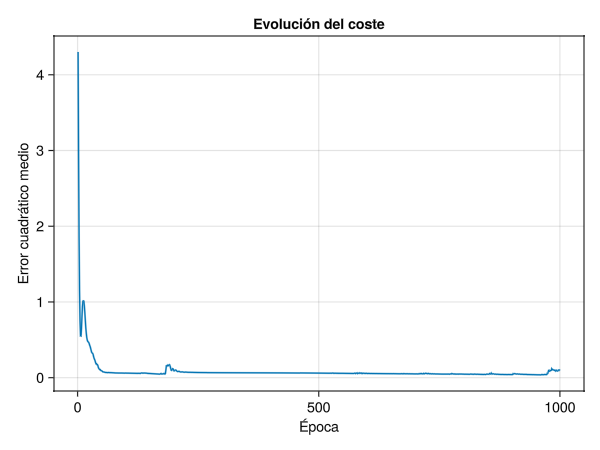

In [17]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

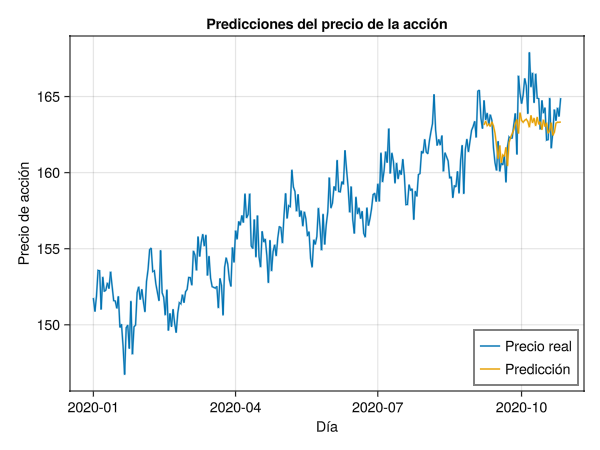

In [18]:
y_test, _ = modelo(Xtest, ps, st)
predicciones = y_test .* σ .+ μ

fig = Figure()
ax = Axis(fig[1,1], xlabel = "Día", ylabel = "Precio de acción", title = "Predicciones del precio de la acción")
lines!(ax, df.dia, df.precio, label = "Precio real")
lines!(ax, df.dia[251:end], vec(predicciones), label = "Predicción")
axislegend(ax, position = :rb)
fig